In [1]:
import matplotlib.pyplot as plt
import shap
import pickle
import cloudpickle
import numpy as np
import scipy as sp
import pandas as pd
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances,\
                       plot_feature_dependence, plot_feature_dependencies
from util import calc_ground_truth_constraints, constraint_matrix_to_rules, RuleClassifier
from clustering import make_clustering
from tasks.feature_ignored import make_task
shap.initjs()
%matplotlib inline

In [2]:
clf_a, clf_b, X, y, feature_names, feature_precisions = make_task()

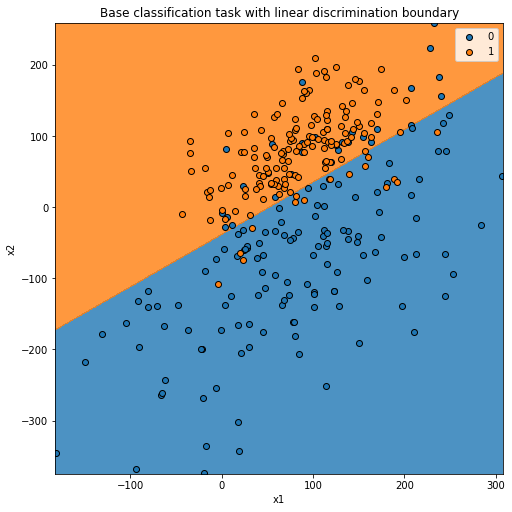

In [3]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
plot_decision_boundary(X, y, 'Base classification task with linear discrimination boundary', feature_names,
                       predict=clf_a.predict, class_names=clf_a.classes_,
                       fig=fig, ax=ax)

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

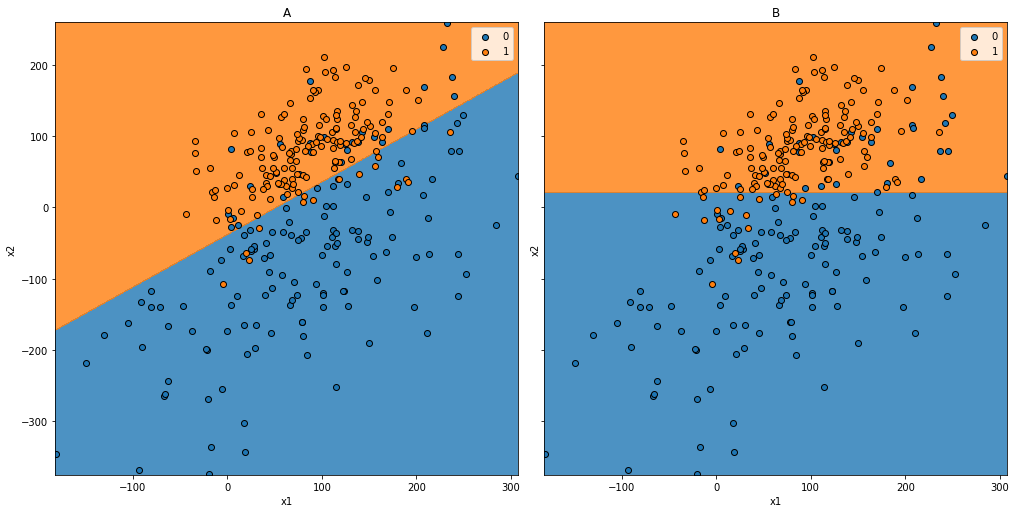

In [4]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='label')
plt.savefig('b-ignores-feature-decision-boundaries-indiv.pdf')

In [4]:
clf_a.coef_, clf_a.intercept_

(array([[-0.02146303,  0.02909487]]), array([1.11018683]))

In [5]:
clf_b.coef_, clf_b.intercept_

(array([[0.        , 0.01784651]]), array([-0.38103095]))

In [6]:
x2_lim = -clf_b.intercept_[0]/clf_b.coef_[0][1]
x2_lim

21.35044499661792

In [7]:
x1_where_x2_crosses = (-clf_a.intercept_[0] - clf_a.coef_[0][1]*x2_lim)/clf_a.coef_[0][0]
x1_where_x2_crosses

80.66778961788788

In [8]:
intercept = -clf_a.intercept_[0]/clf_a.coef_[0][1]
intercept

-38.15747075547969

In [9]:
slope = -clf_a.coef_[0][0]/clf_a.coef_[0][1]
slope

0.7376911656310202

A logistic regression model discriminates at 0, therefore the decision boundary is given by the function $\beta_0 + \beta_1 x_1 + \beta_2 x_2 = 0$

The decision boundary for A can be expressed as a function of $x_1$: $f(x_1) = -\frac{\beta_0}{\beta_2} - \frac{\beta_1}{\beta_2}x_1$

Since for B it is true that $\beta_1=0$, then the decision boundary is given by $x_2^*=\frac{-\beta_0}{\beta_2}$

- $x_1 > 80.67 \land 21.35 < x2 \leq -38.16 + 0.74 x_1$
- $x_1 \leq 80.67 \land -38.16 + 0.74 x_1 < x2 \leq 21.35$

In [10]:
rules_01 = [f'x1 > {x1_where_x2_crosses} and {x2_lim} < x2 <= {intercept} + {slope} * x1']
rules_01

['x1 > 80.66778961788788 and 21.35044499661792 < x2 <= -38.15747075547969 + 0.7376911656310202 * x1']

In [11]:
rules_10 = [f'x1 <= {x1_where_x2_crosses} and {intercept} + {slope} * x1 < x2 <= {x2_lim}']
rules_10

['x1 <= 80.66778961788788 and -38.15747075547969 + 0.7376911656310202 * x1 < x2 <= 21.35044499661792']

In [12]:
def calc_01_x2_boundaries(x1):
    if x1 <= x1_where_x2_crosses:
        raise Exception('invalid x1 value')
    lower_boundary = x2_lim
    upper_boundary = intercept + slope * x1
    return lower_boundary, upper_boundary

In [13]:
def calc_01_x1_boundaries(x2):
    if x2 <= x2_lim:
        raise Exception('invalid x2 value')
    lower_boundary = (x2 - intercept)/slope
    upper_boundary = np.nan
    return lower_boundary, upper_boundary

In [14]:
def calc_10_x2_boundaries(x1):
    if x1 > x1_where_x2_crosses:
        raise Exception('invalid x1 value')
    lower_boundary = intercept + slope * x1
    upper_boundary = x2_lim
    return lower_boundary, upper_boundary

In [15]:
def calc_10_x1_boundaries(x2):
    if x2 > x2_lim:
        raise Exception('invalid x2 value')
    lower_boundary = np.nan
    upper_boundary = (x2 - intercept)/slope
    return lower_boundary, upper_boundary

In [16]:
rclf = RuleClassifier(feature_names, rules_01)

In [17]:
calc_01_x2_boundaries(200)

(21.35044499661792, 109.38076237072434)

In [18]:
X_test = [[200, 110]]
rclf.predict(X_test), comparer.class_names[comparer.predict_mclass_diff(X_test)]

(array([False]), array(['(1, 1)'], dtype='<U6'))

In [19]:
X_test = [[200, 109]]
rclf.predict(X_test), comparer.class_names[comparer.predict_mclass_diff(X_test)]

(array([ True]), array(['(0, 1)'], dtype='<U6'))

In [20]:
calc_01_x1_boundaries(109)

(199.48384583079743, nan)

In [21]:
X_test = [[199, 109]]
rclf.predict(X_test), comparer.class_names[comparer.predict_mclass_diff(X_test)]

(array([False]), array(['(1, 1)'], dtype='<U6'))

In [22]:
X_test = [[200, 109]]
rclf.predict(X_test), comparer.class_names[comparer.predict_mclass_diff(X_test)]

(array([ True]), array(['(0, 1)'], dtype='<U6'))

In [23]:
rclf = RuleClassifier(feature_names, rules_10)

In [24]:
calc_10_x2_boundaries(0)

(-38.15747075547969, 21.35044499661792)

In [25]:
X_test = [[0, -38]]
rclf.predict(X_test), comparer.class_names[comparer.predict_mclass_diff(X_test)]

(array([ True]), array(['(1, 0)'], dtype='<U6'))

In [26]:
X_test = [[0, -39]]
rclf.predict(X_test), comparer.class_names[comparer.predict_mclass_diff(X_test)]

(array([False]), array(['(0, 0)'], dtype='<U6'))

In [27]:
calc_10_x1_boundaries(-38)

(nan, 0.21346433686106667)

In [28]:
X_test = [[0, -38]]
rclf.predict(X_test), comparer.class_names[comparer.predict_mclass_diff(X_test)]

(array([ True]), array(['(1, 0)'], dtype='<U6'))

In [29]:
X_test = [[1, -38]]
rclf.predict(X_test), comparer.class_names[comparer.predict_mclass_diff(X_test)]

(array([False]), array(['(0, 0)'], dtype='<U6'))

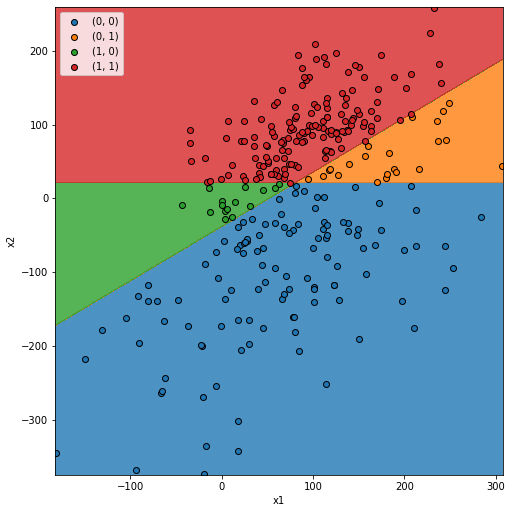

In [31]:
comparer.plot_decision_boundaries(X)
plt.savefig('b-ignores-feature-decision-boundaries-diffclf.pdf')

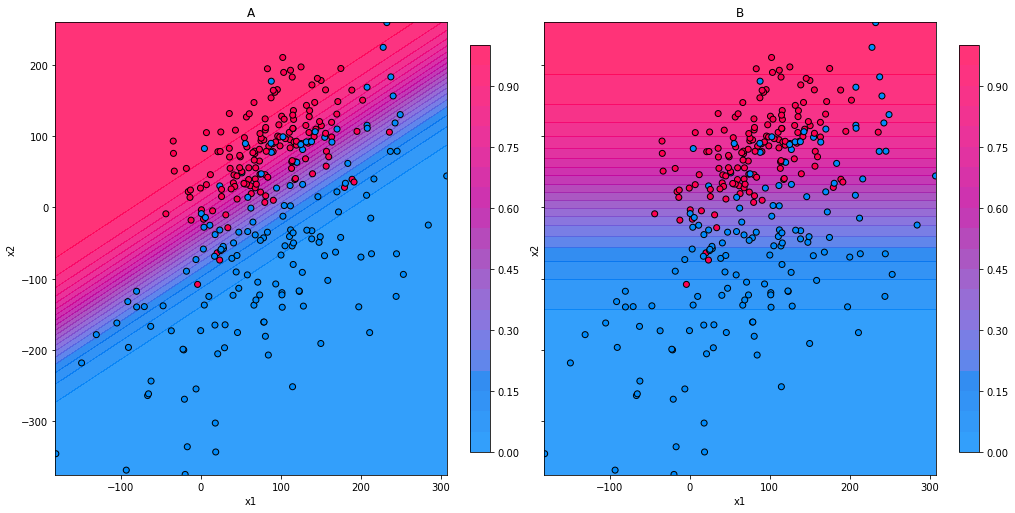

In [32]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='proba')
plt.savefig('b-ignores-feature-decision-boundaries-indiv-proba.pdf')

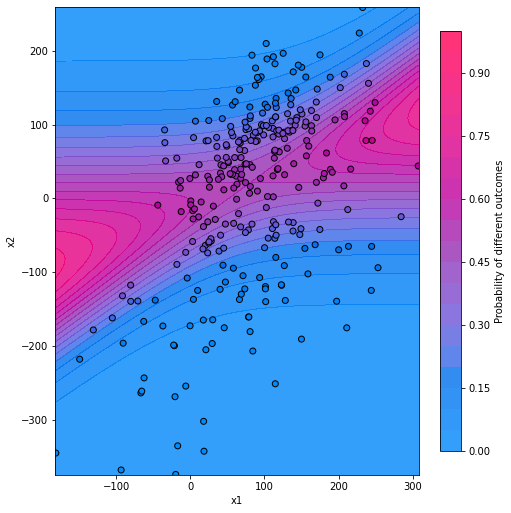

In [33]:
comparer.plot_decision_boundaries(X, kind='proba', type='bin-diffclf')

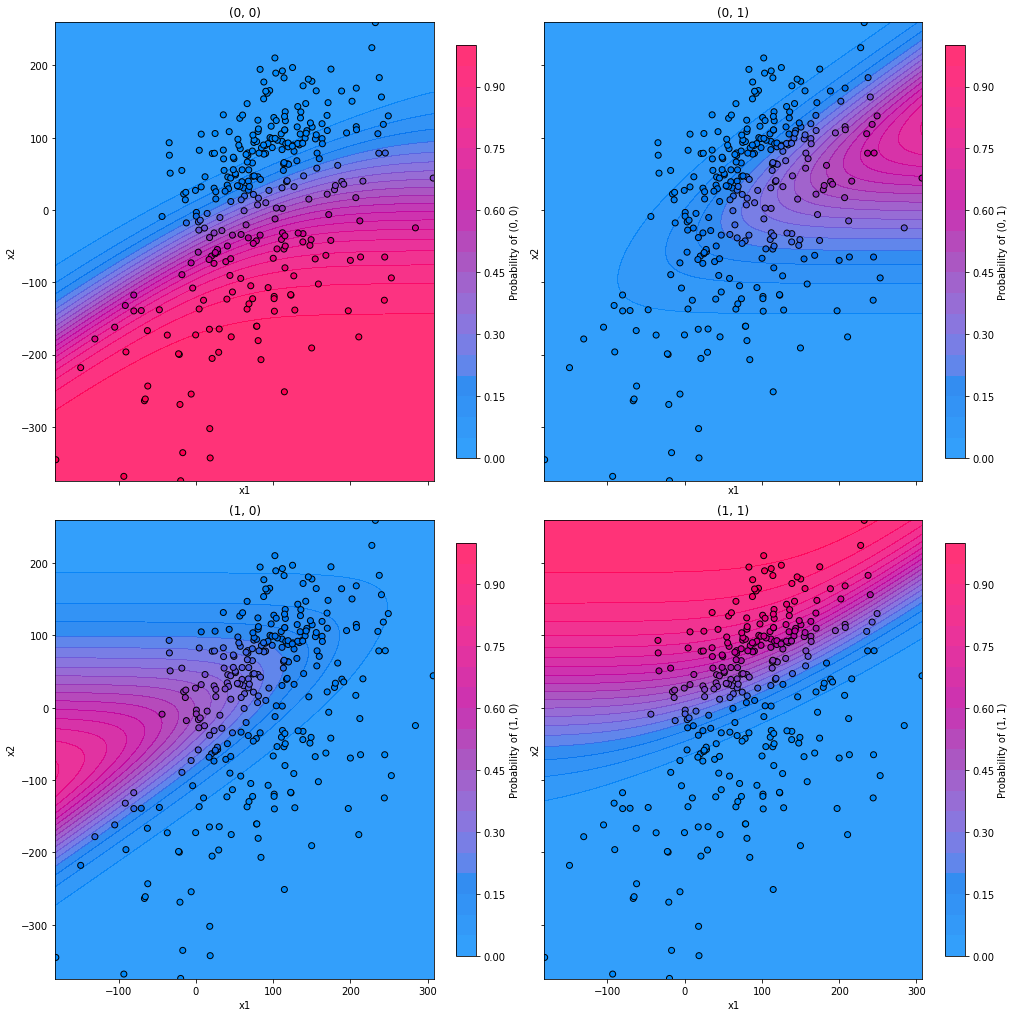

In [34]:
comparer.plot_decision_boundaries(X, kind='proba', type='mclass-diffclf')
plt.savefig('b-ignores-feature-decision-boundaries-diffclf-mclass-proba.pdf')

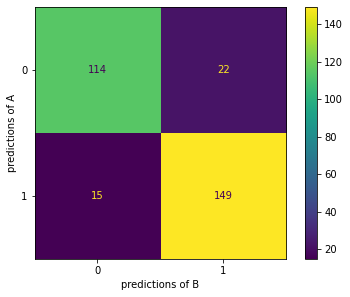

In [35]:
comparer.plot_confusion_matrix(X)
plt.savefig('b-ignores-feature-cm.pdf')

# Ground Truth

In [44]:
mclass_diff = comparer.predict_mclass_diff(X)

In [45]:
label_idx, label_name = comparer.check_class('(0, 1)')

instance_indices = np.where(mclass_diff == label_idx)[0]
ground_truth = np.array([
    [calc_01_x1_boundaries(x[1]),
     calc_01_x2_boundaries(x[0])]
    for x in X[instance_indices]])
with open(f'ground_truth.{label_name}.pickle', 'wb') as f:
    pickle.dump((instance_indices, ground_truth), f)

In [46]:
rules = constraint_matrix_to_rules(ground_truth, feature_names, precisions=feature_precisions, latex=True)
for instance_idx, rule in zip(instance_indices, rules):
    print(f'\item {instance_idx}: ${rule}$')

\item 44: $\mathit{x_1} > 111.4 \land 21.4 < \mathit{x_2} \leq 188.4$
\item 51: $\mathit{x_1} > 147.8 \land 21.4 < \mathit{x_2} \leq 79.7$
\item 58: $\mathit{x_1} > 158.4 \land 21.4 < \mathit{x_2} \leq 142.7$
\item 60: $\mathit{x_1} > 89.6 \land 21.4 < \mathit{x_2} \leq 94.2$
\item 69: $\mathit{x_1} > 135.2 \land 21.4 < \mathit{x_2} \leq 97.3$
\item 78: $\mathit{x_1} > 129.9 \land 21.4 < \mathit{x_2} \leq 77.3$
\item 96: $\mathit{x_1} > 104.7 \land 21.4 < \mathit{x_2} \leq 48.4$
\item 148: $\mathit{x_1} > 106.5 \land 21.4 < \mathit{x_2} \leq 49.0$
\item 170: $\mathit{x_1} > 115.5 \land 21.4 < \mathit{x_2} \leq 64.7$
\item 177: $\mathit{x_1} > 97.5 \land 21.4 < \mathit{x_2} \leq 95.1$
\item 195: $\mathit{x_1} > 88.3 \land 21.4 < \mathit{x_2} \leq 31.6$
\item 207: $\mathit{x_1} > 105.1 \land 21.4 < \mathit{x_2} \leq 101.2$
\item 221: $\mathit{x_1} > 95.3 \land 21.4 < \mathit{x_2} \leq 55.6$
\item 224: $\mathit{x_1} > 105.7 \land 21.4 < \mathit{x_2} \leq 121.3$
\item 229: $\mathit{x_1} > 

In [47]:
label_idx, label_name = comparer.check_class('(1, 0)')

instance_indices = np.where(mclass_diff == label_idx)[0]
ground_truth = np.array([
    [calc_10_x1_boundaries(x[1]),
     calc_10_x2_boundaries(x[0])]
    for x in X[instance_indices]])
with open(f'ground_truth.{label_name}.pickle', 'wb') as f:
    pickle.dump((instance_indices, ground_truth), f)

In [48]:
rules = constraint_matrix_to_rules(ground_truth, feature_names, precisions=feature_precisions, latex=True)
for instance_idx, rule in zip(instance_indices, rules):
    print(f'\item {instance_idx}: ${rule}$')

\item 17: $\mathit{x_1} \leq 47.0 \land -37.6 < \mathit{x_2} \leq 21.4$
\item 19: $\mathit{x_1} \leq 17.7 \land -29.9 < \mathit{x_2} \leq 21.4$
\item 46: $\mathit{x_1} \leq 27.4 \land -47.2 < \mathit{x_2} \leq 21.4$
\item 128: $\mathit{x_1} \leq 77.8 \land 8.3 < \mathit{x_2} \leq 21.4$
\item 134: $\mathit{x_1} \leq 45.1 \land -27.4 < \mathit{x_2} \leq 21.4$
\item 199: $\mathit{x_1} \leq 39.9 \land -37.7 < \mathit{x_2} \leq 21.4$
\item 201: $\mathit{x_1} \leq 13.9 \land -35.3 < \mathit{x_2} \leq 21.4$
\item 226: $\mathit{x_1} \leq 29.2 \land -35.7 < \mathit{x_2} \leq 21.4$
\item 231: $\mathit{x_1} \leq 32.4 \land -34.0 < \mathit{x_2} \leq 21.4$
\item 235: $\mathit{x_1} \leq 70.6 \land -48.2 < \mathit{x_2} \leq 21.4$
\item 248: $\mathit{x_1} \leq 70.7 \land 5.1 < \mathit{x_2} \leq 21.4$
\item 257: $\mathit{x_1} \leq 39.4 \land -70.4 < \mathit{x_2} \leq 21.4$
\item 271: $\mathit{x_1} \leq 67.5 \land -4.8 < \mathit{x_2} \leq 21.4$
\item 276: $\mathit{x_1} \leq 72.3 \land -19.1 < \mathit{x_

# Special Notes on Evaluation

This task serves to test the interpretability methods' generalization capabilities. Therefore, they will be used to create explanations on at least three different levels:
- global level: as simple as possible to describe the differences
    - 2 rules with 6 constraints achieve optimal selectiveness
- intermediate level(s): better fidelity but higher complexity than global level explanations
- local level: again better fidelity and higher complexity, but not too much complexity, so that they are still interpretable. Each method should state it's own rules as to how many rules to generate, I will evaluate afterwards which are more satisfying.

For the first time, probability estimates are available that can be made use of by the interpretability methods.

# Results

In [4]:
with open('results.baseline.pickle', 'rb') as f:
    global_fidelity_baseline, local_fidelity_baseline, complexity_baseline = pickle.load(f)
with open('results.soa.pickle', 'rb') as f:
    global_fidelity_soa, local_fidelity_soa, complexity_soa = pickle.load(f)
with open('results.proposed.pickle', 'rb') as f:
    global_fidelity_proposed, local_fidelity_proposed, complexity_proposed = pickle.load(f)

In [5]:
global_fidelity = pd.concat([global_fidelity_baseline, global_fidelity_soa, global_fidelity_proposed],
                            keys=['BA', 'SOA', 'PA'], names=['approach'])
global_fidelity = global_fidelity.reorder_levels(['level', 'class', 'approach']).sort_index()
global_fidelity

Precision    Recall  F1 Score  Support
level  class  approach                                        
global (0, 1) BA         0.866667  0.590909  0.702703     22.0
              PA         0.222222  1.000000  0.363636     22.0
              SOA        0.256098  0.954545  0.403846     22.0
       (1, 0) BA         1.000000  0.933333  0.965517     15.0
              PA         0.454545  1.000000  0.625000     15.0
              SOA        0.202899  0.933333  0.333333     15.0
local  (0, 1) BA         1.000000  1.000000  1.000000     22.0
              PA         0.241758  1.000000  0.389381     22.0
              SOA        0.687500  1.000000  0.814815     22.0
       (1, 0) BA         1.000000  1.000000  1.000000     15.0
              PA         0.468750  1.000000  0.638298     15.0
              SOA        0.882353  1.000000  0.937500     15.0

In [6]:
print(global_fidelity.to_latex(float_format="%.2f"))

\begin{tabular}{lllrrrr}
\toprule
      &        &     &  Precision &  Recall &  F1 Score &  Support \\
level & class & approach &            &         &           &          \\
\midrule
global & (0, 1) & BA &       0.87 &    0.59 &      0.70 &    22.00 \\
      &        & PA &       0.22 &    1.00 &      0.36 &    22.00 \\
      &        & SOA &       0.26 &    0.95 &      0.40 &    22.00 \\
      & (1, 0) & BA &       1.00 &    0.93 &      0.97 &    15.00 \\
      &        & PA &       0.45 &    1.00 &      0.62 &    15.00 \\
      &        & SOA &       0.20 &    0.93 &      0.33 &    15.00 \\
local & (0, 1) & BA &       1.00 &    1.00 &      1.00 &    22.00 \\
      &        & PA &       0.24 &    1.00 &      0.39 &    22.00 \\
      &        & SOA &       0.69 &    1.00 &      0.81 &    22.00 \\
      & (1, 0) & BA &       1.00 &    1.00 &      1.00 &    15.00 \\
      &        & PA &       0.47 &    1.00 &      0.64 &    15.00 \\
      &        & SOA &       0.88 &    1.00 &     

In [7]:
local_fidelity = pd.concat([local_fidelity_baseline, local_fidelity_soa, local_fidelity_proposed],
                             axis=1, keys=['BA', 'SOA', 'PA'], names=['approach', 'metric'])
local_fidelity = local_fidelity.reorder_levels(['metric', 'approach'], axis=1).sort_index(axis=1)
local_fidelity = local_fidelity.reorder_levels(['level', 'class', 'feature']).sort_index()
local_fidelity

metric                      BAR                      BMR                 RMSE  \
approach                     BA   PA       SOA        BA   PA  SOA         BA   
level  class  feature                                                           
global (0, 1) x1       0.000000  0.0  0.000000  0.000000  0.0  0.0  56.719973   
              x2       0.000000  0.0  0.000000  0.000000  0.0  0.5  21.719044   
       (1, 0) x1       0.000000  0.0  0.000000  0.000000  0.0  0.0  25.511318   
              x2       0.000000  0.0  0.000000  0.000000  0.0  0.5  13.079858   
local  (0, 1) x1       0.290323  0.0  0.153846  0.000000  0.0  0.0  42.471898   
              x2       0.000000  0.0  0.000000  0.000000  0.0  0.0  28.821990   
       (1, 0) x1       0.066667  0.0  0.166667  0.066667  0.0  0.0  25.511318   
              x2       0.000000  0.0  0.000000  0.000000  0.0  0.0  12.763699   

metric                                       
approach                      PA        SOA  
level  class  feature                        
global (0, 1) x1       65.168513  48.687043  
              x2       69.752554   0.031510  
       (1, 0) x1       37.821959  26.357963  
              x2       32.880167   0.026692  
local  (0, 1) x1       20.112083  19.882850  
              x2       15.479599  33.931441  
       (1, 0) x1       14.488458  12.388852  
              x2       22.942462  20.460799

In [8]:
local_fidelity.to_latex(float_format="%.2f")\
    .replace()

\begin{tabular}{lllrrrrrrrrr}
\toprule
      &        & metric & \multicolumn{3}{l}{BAR} & \multicolumn{3}{l}{BMR} & \multicolumn{3}{l}{RMSE} \\
      &        & approach &   BA &   PA &  SOA &   BA &   PA &  SOA &    BA &    PA &   SOA \\
level & class & feature &      &      &      &      &      &      &       &       &       \\
\midrule
global & (0, 1) & x1 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 56.72 & 65.17 & 48.69 \\
      &        & x2 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.50 & 21.72 & 69.75 &  0.03 \\
      & (1, 0) & x1 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 25.51 & 37.82 & 26.36 \\
      &        & x2 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.50 & 13.08 & 32.88 &  0.03 \\
local & (0, 1) & x1 & 0.29 & 0.00 & 0.15 & 0.00 & 0.00 & 0.00 & 42.47 & 20.11 & 19.88 \\
      &        & x2 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 28.82 & 15.48 & 33.93 \\
      & (1, 0) & x1 & 0.07 & 0.00 & 0.17 & 0.07 & 0.00 & 0.00 & 25.51 & 14.49 & 12.39 \\
      &        & x2 & 0.00 & 0.00 

In [96]:
complexity = pd.concat([complexity_baseline, complexity_soa, complexity_proposed],
                       keys=['BA', 'SOA', 'PA'], names=['approach'])
complexity = complexity.reorder_levels(['level', 'class', 'approach']).sort_index()
complexity

Rules  Constraints
level  class  approach                    
global (0, 1) BA            1            3
              PA            1            3
              SOA           1            2
       (1, 0) BA            1            3
              PA            1            3
              SOA           1            2
local  (0, 1) BA            4           14
              PA            6           18
              SOA           5           17
       (1, 0) BA            2            6
              PA            3            9
              SOA           4           14

In [97]:
print(complexity.to_latex())

\begin{tabular}{lllrr}
\toprule
      &        &     &  Rules &  Constraints \\
level & class & approach &        &              \\
\midrule
global & (0, 1) & BA &      1 &            3 \\
      &        & PA &      1 &            3 \\
      &        & SOA &      1 &            2 \\
      & (1, 0) & BA &      1 &            3 \\
      &        & PA &      1 &            3 \\
      &        & SOA &      1 &            2 \\
local & (0, 1) & BA &      4 &           14 \\
      &        & PA &      6 &           18 \\
      &        & SOA &      5 &           17 \\
      & (1, 0) & BA &      2 &            6 \\
      &        & PA &      3 &            9 \\
      &        & SOA &      4 &           14 \\
\bottomrule
\end{tabular}



In [99]:
generation_time = pd.DataFrame({
    'SOA': '15m',
    'BA': '<1s',
    'PA': '50s'}, index=['Time']).T
generation_time

,Time
SOA,15m
BA,<1s
PA,50s


In [100]:
print(generation_time.to_latex())

\begin{tabular}{ll}
\toprule
{} & Time \\
\midrule
SOA &  15m \\
BA  &  <1s \\
PA  &  50s \\
\bottomrule
\end{tabular}



# Additional Plots

In [5]:
from explainers import plot_feature_dependence
import shap

In [6]:
with open('indiv.log_odds.shap', 'rb') as f:
    shap_values = pickle.load(f)

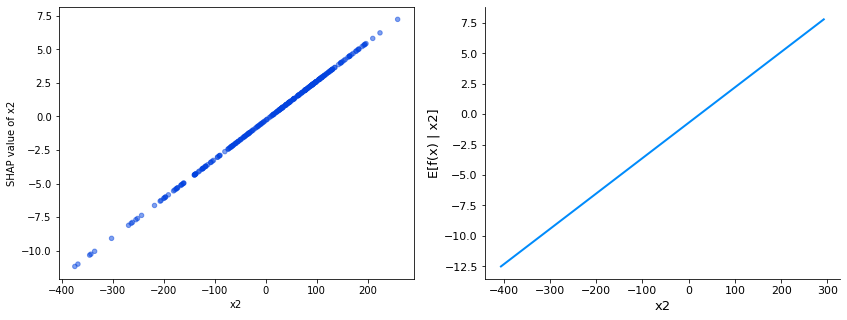

In [7]:
feature_idx, feature_name = comparer.check_feature('x2')
fig, axs = plt.subplots(ncols=2, figsize=(2*7, 5))
plot_feature_dependence(shap_values[:, :, 'A.1'], feature_idx, alpha=0.5, ax=axs[0], show=False)
shap.plots.partial_dependence(ind=feature_idx,
                              model=lambda X: comparer.predict_combined_log_odds(X)[:, 1],
                              data=X,
                              feature_names=feature_names,
                              ice=False, hist=False, ax=axs[1])

In [8]:
with open('diffclf.log_odds.shap', 'rb') as f:
    shap_values = pickle.load(f)

In [9]:
focus_class_idx, focus_class = comparer.check_class('(0, 1)')

In [10]:
is_different = comparer.predict_bin_diff(X)

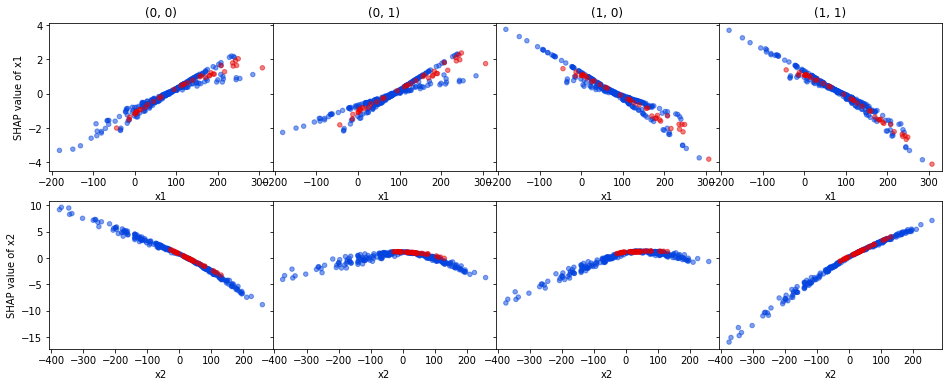

In [11]:
plot_feature_dependencies(shap_values, color=is_different, alpha=0.5, figsize=(4, 3))

In [12]:
feature_idx, feature_name = comparer.check_feature('x2')

SHAP Dependence Plot vs. PDP

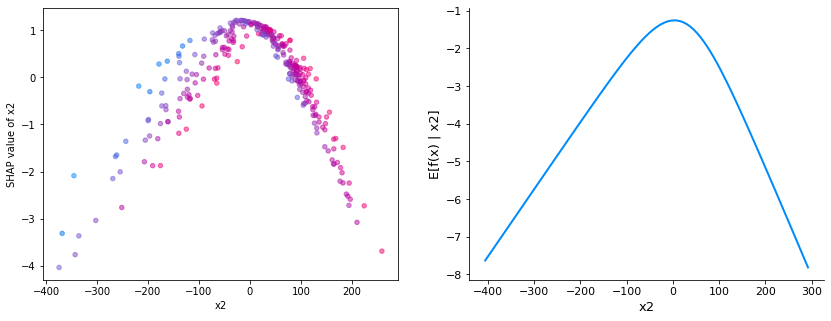

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(2*7, 5))
plot_feature_dependence(shap_values[:, :, focus_class], feature_idx, alpha=0.5, ax=axs[0], show=False,
                        color=shap_values[:, 'x1', focus_class].data, color_label='x1')
shap.plots.partial_dependence(ind=feature_idx,
                              model=lambda X: comparer.predict_mclass_diff_log_odds(X)[:, focus_class_idx],
                              data=X,
                              feature_names=feature_names,
                              ice=False, hist=False, ax=axs[1])

In [14]:
from importlib import reload
import explainers
reload(explainers)
from explainers import *

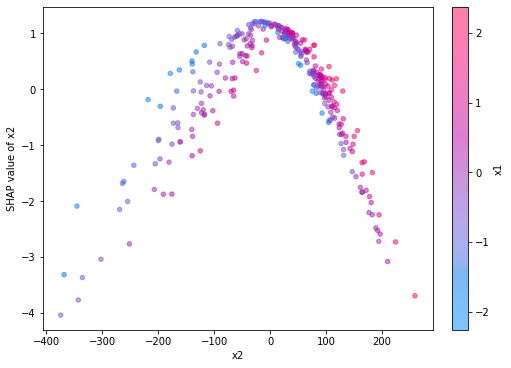

In [15]:
plot_feature_dependence(shap_values[:, :, focus_class], feature_idx, alpha=0.5,
                        color=shap_values[:, 'x1', focus_class].values, color_label='x1')

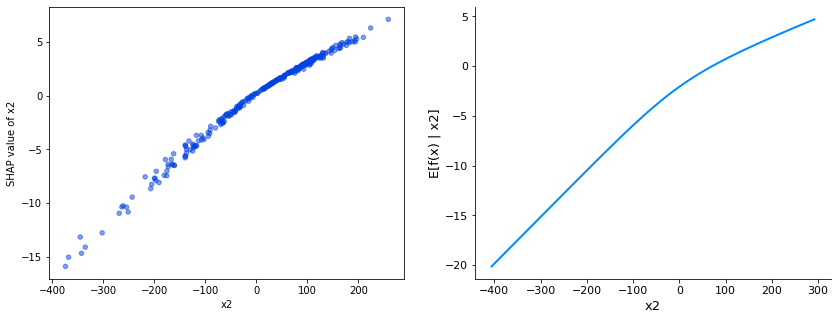

In [16]:
feature_idx, feature_name = comparer.check_feature('x2')
focus_class_idx, focus_class = comparer.check_class('(1, 1)')
fig, axs = plt.subplots(ncols=2, figsize=(2*7, 5))
plot_feature_dependence(shap_values[:, :, focus_class], feature_idx, alpha=0.5, ax=axs[0], show=False)
shap.plots.partial_dependence(ind=feature_idx,
                              model=lambda X: comparer.predict_mclass_diff_log_odds(X)[:, focus_class_idx],
                              data=X,
                              feature_names=feature_names,
                              ice=False, hist=False, ax=axs[1])

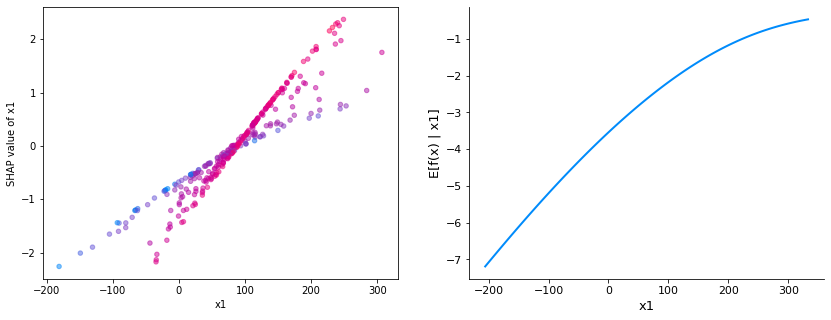

In [17]:
feature_idx, feature_name = comparer.check_feature('x1')
focus_class_idx, focus_class = comparer.check_class('(0, 1)')
fig, axs = plt.subplots(ncols=2, figsize=(2*7, 5))
plot_feature_dependence(shap_values[:, :, focus_class], feature_idx, alpha=0.5, ax=axs[0], show=False,
                        color=shap_values[:, 'x2', focus_class].data, color_label='x2')
shap.plots.partial_dependence(ind=feature_idx,
                              model=lambda X: comparer.predict_mclass_diff_log_odds(X)[:, focus_class_idx],
                              data=X,
                              feature_names=feature_names,
                              ice=False, hist=False, ax=axs[1])